In [1]:
import math
import random
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union

import torch
from torch import Tensor, nn
from timm import create_model

In [2]:
class DetrFrozenBatchNorm2d(nn.Module):
    """
    BatchNorm2d where the batch statistics and the affine parameters are fixed.
    Copy-paste from torchvision.misc.ops with added eps before rqsrt, without which any other models than
    torchvision.models.resnet[18,34,50,101] produce nans.
    """

    def __init__(self, n):
        super().__init__()
        self.register_buffer("weight", torch.ones(n))
        self.register_buffer("bias", torch.zeros(n))
        self.register_buffer("running_mean", torch.zeros(n))
        self.register_buffer("running_var", torch.ones(n))

    def _load_from_state_dict(
        self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs
    ):
        num_batches_tracked_key = prefix + "num_batches_tracked"
        if num_batches_tracked_key in state_dict:
            del state_dict[num_batches_tracked_key]

        super()._load_from_state_dict(
            state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs
        )

    def forward(self, x):
        # move reshapes to the beginning
        # to make it user-friendly
        weight = self.weight.reshape(1, -1, 1, 1)
        bias = self.bias.reshape(1, -1, 1, 1)
        running_var = self.running_var.reshape(1, -1, 1, 1)
        running_mean = self.running_mean.reshape(1, -1, 1, 1)
        epsilon = 1e-5
        scale = weight * (running_var + epsilon).rsqrt()
        bias = bias - running_mean * scale
        return x * scale + bias

In [3]:
def replace_batch_norm(m, name=""):
    for attr_str in dir(m):
        target_attr = getattr(m, attr_str)
        if isinstance(target_attr, nn.BatchNorm2d):
            frozen = DetrFrozenBatchNorm2d(target_attr.num_features)
            bn = getattr(m, attr_str)
            frozen.weight.data.copy_(bn.weight)
            frozen.bias.data.copy_(bn.bias)
            frozen.running_mean.data.copy_(bn.running_mean)
            frozen.running_var.data.copy_(bn.running_var)
            setattr(m, attr_str, frozen)
    for n, ch in m.named_children():
        replace_batch_norm(ch, n)

In [4]:
class DetrConvEncoder(nn.Module):
    """
    Convolutional backbone, using either the AutoBackbone API or one from the timm library.
    nn.BatchNorm2d layers are replaced by DetrFrozenBatchNorm2d as defined above.
    """

    def __init__(self, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config,):
        super().__init__()

        self.use_timm_backbone = use_timm_backbone

        if use_timm_backbone:
            #requires_backends(self, ["timm"])
            kwargs = {}
            if dilation:
                kwargs["output_stride"] = 16
            backbone1 = create_model(
                backbone,
                pretrained=use_pretrained_backbone,
                features_only=True,
                out_indices=(1, 2, 3, 4),
                in_chans=num_channels,
                **kwargs,
            )
        else:
            backbone = AutoBackbone.from_config(backbone_config)

        # replace batch norm by frozen batch norm
        with torch.no_grad():
            replace_batch_norm(backbone1)
        self.model = backbone1
        self.intermediate_channel_sizes = (
            self.model.feature_info.channels() if use_timm_backbone else self.model.channels
        )

        backbone_model_type = backbone if use_timm_backbone else backbone_config.model_type
        if "resnet" in backbone_model_type:
            for name, parameter in self.model.named_parameters():
                if use_timm_backbone:
                    if "layer2" not in name and "layer3" not in name and "layer4" not in name:
                        parameter.requires_grad_(False)
                else:
                    if "stage.1" not in name and "stage.2" not in name and "stage.3" not in name:
                        parameter.requires_grad_(False)

    def forward(self, pixel_values: torch.Tensor, pixel_mask: torch.Tensor):
        # send pixel_values through the model to get list of feature maps
        features = self.model(pixel_values) if self.use_timm_backbone else self.model(pixel_values).feature_maps

        out = []
        for feature_map in features:
            # downsample pixel_mask to match shape of corresponding feature_map
            mask = nn.functional.interpolate(pixel_mask[None].float(), size=feature_map.shape[-2:]).to(torch.bool)[0]
            out.append((feature_map, mask))
        return out

In [5]:
class DetrConvModel(nn.Module):
    """
    This module adds 2D position embeddings to all intermediate feature maps of the convolutional encoder.
    """

    def __init__(self, conv_encoder, position_embedding):
        super().__init__()
        self.conv_encoder = conv_encoder
        self.position_embedding = position_embedding

    def forward(self, pixel_values, pixel_mask):
        # send pixel_values and pixel_mask through backbone to get list of (feature_map, pixel_mask) tuples
        out = self.conv_encoder(pixel_values, pixel_mask)
        pos = []
        for feature_map, mask in out:
            # position encoding
            pos.append(self.position_embedding(feature_map, mask).to(feature_map.dtype))

        return out, pos

In [6]:
def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, target_len: Optional[int] = None):
    """
    Expands attention_mask from `[batch_size, seq_len]` to `[batch_size, 1, target_seq_len, source_seq_len]`.
    """
    batch_size, source_len = mask.size()
    target_len = target_len if target_len is not None else source_len

    expanded_mask = mask[:, None, None, :].expand(batch_size, 1, target_len, source_len).to(dtype)

    inverted_mask = 1.0 - expanded_mask

    return inverted_mask.masked_fill(inverted_mask.bool(), torch.finfo(dtype).min)

In [7]:
class DetrSinePositionEmbedding(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one used by the Attention is all you
    need paper, generalized to work on images.
    """

    def __init__(self, embedding_dim=64, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, pixel_values, pixel_mask):
        if pixel_mask is None:
            raise ValueError("No pixel mask provided")
        y_embed = pixel_mask.cumsum(1, dtype=torch.float32)
        x_embed = pixel_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            y_embed = y_embed / (y_embed[:, -1:, :] + 1e-6) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + 1e-6) * self.scale

        dim_t = torch.arange(self.embedding_dim, dtype=torch.float32, device=pixel_values.device)
        dim_t = self.temperature ** (2 * torch.div(dim_t, 2, rounding_mode="floor") / self.embedding_dim)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

In [8]:
class DetrLearnedPositionEmbedding(nn.Module):
    """
    This module learns positional embeddings up to a fixed maximum size.
    """

    def __init__(self, embedding_dim=256):
        super().__init__()
        self.row_embeddings = nn.Embedding(50, embedding_dim)
        self.column_embeddings = nn.Embedding(50, embedding_dim)

    def forward(self, pixel_values, pixel_mask=None):
        height, width = pixel_values.shape[-2:]
        width_values = torch.arange(width, device=pixel_values.device)
        height_values = torch.arange(height, device=pixel_values.device)
        x_emb = self.column_embeddings(width_values)
        y_emb = self.row_embeddings(height_values)
        pos = torch.cat([x_emb.unsqueeze(0).repeat(height, 1, 1), y_emb.unsqueeze(1).repeat(1, width, 1)], dim=-1)
        pos = pos.permute(2, 0, 1)
        pos = pos.unsqueeze(0)
        pos = pos.repeat(pixel_values.shape[0], 1, 1, 1)
        return pos


In [9]:
def build_position_encoding(d_model, position_embedding_type):
    n_steps = d_model // 2
    if position_embedding_type == "sine":
        # TODO find a better way of exposing other arguments
        position_embedding = DetrSinePositionEmbedding(n_steps, normalize=True)
    elif position_embedding_type == "learned":
        position_embedding = DetrLearnedPositionEmbedding(n_steps)
    else:
        raise ValueError(f"Not supported {position_embedding_type}")

    return position_embedding


In [10]:
class DetrAttention(nn.Module):
    """
    Multi-headed attention from 'Attention Is All You Need' paper.
    Here, we add position embeddings to the queries and keys (as explained in the DETR paper).
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        if self.head_dim * num_heads != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim} and `num_heads`:"
                f" {num_heads})."
            )
        self.scaling = self.head_dim**-0.5

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

    def _shape(self, tensor: torch.Tensor, seq_len: int, batch_size: int):
        return tensor.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    def with_pos_embed(self, tensor: torch.Tensor, position_embeddings: Optional[Tensor]):
        return tensor if position_embeddings is None else tensor + position_embeddings

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_embeddings: Optional[torch.Tensor] = None,
        key_value_states: Optional[torch.Tensor] = None,
        key_value_position_embeddings: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None
        batch_size, target_len, embed_dim = hidden_states.size()

        # add position embeddings to the hidden states before projecting to queries and keys
        if position_embeddings is not None:
            hidden_states_original = hidden_states
            hidden_states = self.with_pos_embed(hidden_states, position_embeddings)

        # add key-value position embeddings to the key value states
        if key_value_position_embeddings is not None:
            key_value_states_original = key_value_states
            key_value_states = self.with_pos_embed(key_value_states, key_value_position_embeddings)

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        if is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, batch_size)
            value_states = self._shape(self.v_proj(key_value_states_original), -1, batch_size)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, batch_size)
            value_states = self._shape(self.v_proj(hidden_states_original), -1, batch_size)

        proj_shape = (batch_size * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, target_len, batch_size).view(*proj_shape)
        key_states = key_states.view(*proj_shape)
        value_states = value_states.view(*proj_shape)

        source_len = key_states.size(1)

        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

        if attn_weights.size() != (batch_size * self.num_heads, target_len, source_len):
            raise ValueError(
                f"Attention weights should be of size {(batch_size * self.num_heads, target_len, source_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (batch_size, 1, target_len, source_len):
                raise ValueError(
                    f"Attention mask should be of size {(batch_size, 1, target_len, source_len)}, but is"
                    f" {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(batch_size, self.num_heads, target_len, source_len) + attention_mask
            attn_weights = attn_weights.view(batch_size * self.num_heads, target_len, source_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(batch_size, self.num_heads, target_len, source_len)
            attn_weights = attn_weights_reshaped.view(batch_size * self.num_heads, target_len, source_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (batch_size * self.num_heads, target_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(batch_size, self.num_heads, target_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(batch_size, self.num_heads, target_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)
        attn_output = attn_output.reshape(batch_size, target_len, embed_dim)

        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights_reshaped

In [11]:
class DetrEncoderLayer(nn.Module):
    def __init__(self, d_model, encoder_attention_heads, attention_dropout, activation_dropout, dropout, encoder_ffn_dim):
        super().__init__()
        self.embed_dim = d_model
        self.self_attn = DetrAttention(
            embed_dim=self.embed_dim,
            num_heads=encoder_attention_heads,
            dropout=attention_dropout,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, encoder_ffn_dim)
        self.fc2 = nn.Linear(encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        position_embeddings: torch.Tensor = None,
        output_attentions: bool = False,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(seq_len, batch, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            position_embeddings (`torch.FloatTensor`, *optional*): position embeddings, to be added to hidden_states.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states, attn_weights = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_embeddings=position_embeddings,
            output_attentions=output_attentions,
        )

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)

        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        if self.training:
            if torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any():
                clamp_value = torch.finfo(hidden_states.dtype).max - 1000
                hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)

        return outputs


In [12]:
class DetrDecoderLayer(nn.Module):
    def __init__(self, d_model, decoder_attention_heads, attention_dropout, activation_dropout, dropout, decoder_ffn_dim):
        super().__init__()
        self.embed_dim = d_model

        self.self_attn = DetrAttention(
            embed_dim=self.embed_dim,
            num_heads=decoder_attention_heads,
            dropout=attention_dropout,
            is_decoder=True,
        )
        self.dropout = dropout
        self.activation_fn = nn.GELU()
        self.activation_dropout = activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = DetrAttention(
            self.embed_dim,
            decoder_attention_heads,
            dropout=attention_dropout,
            is_decoder=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, decoder_ffn_dim)
        self.fc2 = nn.Linear(decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_embeddings: Optional[torch.Tensor] = None,
        query_position_embeddings: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = False,
    ):
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(seq_len, batch, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            position_embeddings (`torch.FloatTensor`, *optional*):
                position embeddings that are added to the queries and keys
            in the cross-attention layer.
            query_position_embeddings (`torch.FloatTensor`, *optional*):
                position embeddings that are added to the queries and keys
            in the self-attention layer.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(seq_len, batch, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, target_len, source_len)` where padding elements are indicated by very large negative
                values.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states

        # Self Attention
        hidden_states, self_attn_weights = self.self_attn(
            hidden_states=hidden_states,
            position_embeddings=query_position_embeddings,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
        )

        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)

        # Cross-Attention Block
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states

            hidden_states, cross_attn_weights = self.encoder_attn(
                hidden_states=hidden_states,
                position_embeddings=query_position_embeddings,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                key_value_position_embeddings=position_embeddings,
                output_attentions=output_attentions,
            )

            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)

        # Fully Connected
        residual = hidden_states
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        hidden_states = self.final_layer_norm(hidden_states)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        return outputs

In [13]:
class DetrClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, input_dim: int, inner_dim: int, num_classes: int, pooler_dropout: float):
        super().__init__()
        self.dense = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=pooler_dropout)
        self.out_proj = nn.Linear(inner_dim, num_classes)

    def forward(self, hidden_states: torch.Tensor):
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

In [14]:
class DetrEncoder(nn.Module):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`DetrEncoderLayer`].
    The encoder updates the flattened feature map through multiple self-attention layers.
    Small tweak for DETR:
    - position_embeddings are added to the forward pass.
    Args:
        config: DetrConfig
    """

    def __init__(self, encoder_layers, encoder_layerdrop, d_model, encoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, encoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict):
        super().__init__()

        self.dropout = dropout
        self.layerdrop = encoder_layerdrop

        self.layers = nn.ModuleList([DetrEncoderLayer(d_model, encoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, encoder_ffn_dim) for _ in range(encoder_layers)])

        # in the original DETR, no layernorm is used at the end of the encoder, as "normalize_before" is set to False by default

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        position_embeddings=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Flattened feature map (output of the backbone + projection layer) that is passed to the encoder.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding pixel features. Mask values selected in `[0, 1]`:
                - 1 for pixel features that are real (i.e. **not masked**),
                - 0 for pixel features that are padding (i.e. **masked**).
                [What are attention masks?](../glossary#attention-mask)
            position_embeddings (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                Position embeddings that are added to the queries and keys in each self-attention layer.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        hidden_states = inputs_embeds
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        # expand attention_mask
        if attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            attention_mask = _expand_mask(attention_mask, inputs_embeds.dtype)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        for i, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                # we add position_embeddings as extra input to the encoder_layer
                layer_outputs = encoder_layer(
                    hidden_states,
                    attention_mask,
                    position_embeddings=position_embeddings,
                    output_attentions=output_attentions,
                )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)

In [15]:
class DetrDecoder(nn.Module):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`DetrDecoderLayer`].
    The decoder updates the query embeddings through multiple self-attention and cross-attention layers.
    Some small tweaks for DETR:
    - position_embeddings and query_position_embeddings are added to the forward pass.
    - if self.config.auxiliary_loss is set to True, also returns a stack of activations from all decoding layers.
    Args:
        config: DetrConfig
    """

    def __init__(self, decoder_layers, decoder_layerdrop, d_model, decoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss):
        super().__init__()
        self.dropout = dropout
        self.layerdrop = decoder_layerdrop

        self.layers = nn.ModuleList([DetrDecoderLayer(d_model, decoder_attention_heads, 
                 attention_dropout, activation_dropout, dropout, decoder_ffn_dim) for _ in range(decoder_layers)])
        # in DETR, the decoder uses layernorm after the last decoder layer output
        self.layernorm = nn.LayerNorm(d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict
        self.auxiliary_loss = auxiliary_loss

    def forward(
        self,
        inputs_embeds=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        position_embeddings=None,
        query_position_embeddings=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
                The query embeddings that are passed into the decoder.
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on certain queries. Mask values selected in `[0, 1]`:
                - 1 for queries that are **not masked**,
                - 0 for queries that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
                Mask to avoid performing cross-attention on padding pixel_values of the encoder. Mask values selected
                in `[0, 1]`:
                - 1 for pixels that are real (i.e. **not masked**),
                - 0 for pixels that are padding (i.e. **masked**).
            position_embeddings (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Position embeddings that are added to the queries and keys in each cross-attention layer.
            query_position_embeddings (`torch.FloatTensor` of shape `(batch_size, num_queries, hidden_size)`):
                , *optional*): Position embeddings that are added to the queries and keys in each self-attention layer.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        if inputs_embeds is not None:
            hidden_states = inputs_embeds
            input_shape = inputs_embeds.size()[:-1]

        combined_attention_mask = None

        if attention_mask is not None and combined_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            combined_attention_mask = combined_attention_mask + _expand_mask(
                attention_mask, inputs_embeds.dtype, target_len=input_shape[-1]
            )

        # expand encoder attention mask
        if encoder_hidden_states is not None and encoder_attention_mask is not None:
            # [batch_size, seq_len] -> [batch_size, 1, target_seq_len, source_seq_len]
            encoder_attention_mask = _expand_mask(
                encoder_attention_mask, inputs_embeds.dtype, target_len=input_shape[-1]
            )

        # optional intermediate hidden states
        intermediate = () if self.auxiliary_loss else None

        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None

        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.layerdrop):
                continue

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(decoder_layer),
                    hidden_states,
                    combined_attention_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    None,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=combined_attention_mask,
                    position_embeddings=position_embeddings,
                    query_position_embeddings=query_position_embeddings,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_attention_mask,
                    output_attentions=output_attentions,
                )

            hidden_states = layer_outputs[0]

            if self.auxiliary_loss:
                hidden_states = self.layernorm(hidden_states)
                intermediate += (hidden_states,)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        # finally, apply layernorm
        hidden_states = self.layernorm(hidden_states)

        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        # stack intermediate decoder activations
        if self.auxiliary_loss:
            intermediate = torch.stack(intermediate)

        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, all_hidden_states, all_self_attns, all_cross_attentions, intermediate]
                if v is not None
            )


In [16]:
class DetrModel(nn.Module):
    def __init__(self, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss):
        super().__init__()

        # Create backbone + positional encoding
        backbone = DetrConvEncoder(use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config)
        position_embeddings = build_position_encoding(d_model, position_embedding_type)
        self.backbone = DetrConvModel(backbone, position_embeddings)

        # Create projection layer
        self.input_projection = nn.Conv2d(backbone.intermediate_channel_sizes[-1], d_model, kernel_size=1)

        self.query_position_embeddings = nn.Embedding(num_queries, d_model)

        self.encoder = DetrEncoder(encoder_layers, encoder_layerdrop, d_model, 
                 encoder_attention_heads, attention_dropout, activation_dropout, 
                 dropout, encoder_ffn_dim, output_attentions, output_hidden_states, 
                 use_return_dict)
        self.decoder = DetrDecoder(decoder_layers, decoder_layerdrop, d_model, 
                 decoder_attention_heads, attention_dropout, activation_dropout, 
                 dropout, decoder_ffn_dim, output_attentions, output_hidden_states, 
                 use_return_dict, auxiliary_loss)

        # Initialize weights and apply final processing
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def freeze_backbone(self):
        for name, param in self.backbone.conv_encoder.model.named_parameters():
            param.requires_grad_(False)

    def unfreeze_backbone(self):
        for name, param in self.backbone.conv_encoder.model.named_parameters():
            param.requires_grad_(True)

    def forward(
        self,
        pixel_values,
        pixel_mask=None,
        decoder_attention_mask=None,
        encoder_outputs=None,
        inputs_embeds=None,
        decoder_inputs_embeds=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Returns:
        Examples:
        ```python
        >>> from transformers import AutoImageProcessor, DetrModel
        >>> from PIL import Image
        >>> import requests
        >>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
        >>> image = Image.open(requests.get(url, stream=True).raw)
        >>> image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")
        >>> model = DetrModel.from_pretrained("facebook/detr-resnet-50")
        >>> # prepare image for the model
        >>> inputs = image_processor(images=image, return_tensors="pt")
        >>> # forward pass
        >>> outputs = model(**inputs)
        >>> # the last hidden states are the final query embeddings of the Transformer decoder
        >>> # these are of shape (batch_size, num_queries, hidden_size)
        >>> last_hidden_states = outputs.last_hidden_state
        >>> list(last_hidden_states.shape)
        [1, 100, 256]
        ```"""
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        batch_size, num_channels, height, width = pixel_values.shape
        device = pixel_values.device

        if pixel_mask is None:
            pixel_mask = torch.ones(((batch_size, height, width)), device=device)

        # First, sent pixel_values + pixel_mask through Backbone to obtain the features
        # pixel_values should be of shape (batch_size, num_channels, height, width)
        # pixel_mask should be of shape (batch_size, height, width)     
        features, position_embeddings_list = self.backbone(pixel_values, pixel_mask)

        # get final feature map and downsampled mask
        feature_map, mask = features[-1]

        if mask is None:
            raise ValueError("Backbone does not return downsampled pixel mask")

        # Second, apply 1x1 convolution to reduce the channel dimension to d_model (256 by default)
        projected_feature_map = self.input_projection(feature_map)

        # Third, flatten the feature map + position embeddings of shape NxCxHxW to NxCxHW, and permute it to NxHWxC
        # In other words, turn their shape into (batch_size, sequence_length, hidden_size)
        flattened_features = projected_feature_map.flatten(2).permute(0, 2, 1)
        position_embeddings = position_embeddings_list[-1].flatten(2).permute(0, 2, 1)

        flattened_mask = mask.flatten(1)

        # Fourth, sent flattened_features + flattened_mask + position embeddings through encoder
        # flattened_features is a Tensor of shape (batch_size, heigth*width, hidden_size)
        # flattened_mask is a Tensor of shape (batch_size, heigth*width)
        
        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                inputs_embeds=flattened_features,
                attention_mask=flattened_mask,
                position_embeddings=position_embeddings,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # Fifth, sent query embeddings + position embeddings through the decoder (which is conditioned on the encoder output)
        query_position_embeddings = self.query_position_embeddings.weight.unsqueeze(0).repeat(batch_size, 1, 1)
        queries = torch.zeros_like(query_position_embeddings)

        # decoder outputs consists of (dec_features, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            inputs_embeds=queries,
            attention_mask=None,
            position_embeddings=position_embeddings,
            query_position_embeddings=query_position_embeddings,
            encoder_hidden_states=encoder_outputs[0],
            encoder_attention_mask=flattened_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if not return_dict:
            return decoder_outputs + encoder_outputs


In [17]:
class DetrForImageClassification(nn.Module):
    def __init__(self, num_labels, use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss) -> None:
        super().__init__()

        self.num_labels = num_labels
        self.use_return_dict = use_return_dict
        self.model = DetrModel(use_timm_backbone, dilation, backbone, use_pretrained_backbone, 
                 num_channels, backbone_config, d_model, num_queries, position_embedding_type, 
                 encoder_layers, decoder_layers, encoder_layerdrop, decoder_layerdrop, 
                 encoder_attention_heads, decoder_attention_heads, attention_dropout, 
                 activation_dropout, dropout, encoder_ffn_dim, decoder_ffn_dim, 
                 output_attentions, output_hidden_states, use_return_dict, auxiliary_loss)
        
        # Classifier head
        self.classifier = nn.Linear(d_model, num_labels) if num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        outputs = self.model(
            pixel_values,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output


In [18]:
num_labels = 10
use_timm_backbone = True
dilation = True
backbone = "resnet50"
use_pretrained_backbone = False
num_channels = 3
backbone_config = None
d_model = 64
num_queries = 10
position_embedding_type = "sine"
encoder_layers = 2
decoder_layers = 2
activation_dropout = 0
dropout = 0
encoder_layerdrop = 0.0
decoder_layerdrop = 0.0
encoder_attention_heads = 2
decoder_attention_heads = 2
attention_dropout = 0.0
encoder_ffn_dim = 64
decoder_ffn_dim = 64
output_attentions = False
output_hidden_states = False
use_return_dict = False
auxiliary_loss = True

modelClassification = DetrForImageClassification(
    num_labels=num_labels,
    use_timm_backbone=use_timm_backbone,
    dilation=dilation,
    backbone=backbone,
    use_pretrained_backbone=use_pretrained_backbone,
    num_channels=num_channels,
    backbone_config=backbone_config,
    d_model=d_model,
    num_queries=num_queries,
    position_embedding_type=position_embedding_type,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    activation_dropout=activation_dropout,
    dropout=dropout,
    encoder_layerdrop=encoder_layerdrop,
    decoder_layerdrop=decoder_layerdrop,
    encoder_attention_heads=encoder_attention_heads,
    decoder_attention_heads=decoder_attention_heads,
    attention_dropout=attention_dropout,
    encoder_ffn_dim=encoder_ffn_dim,
    decoder_ffn_dim=decoder_ffn_dim,
    output_attentions=output_attentions,
    output_hidden_states=output_hidden_states,
    use_return_dict=use_return_dict,
    auxiliary_loss=auxiliary_loss
)

In [19]:
images = torch.randn(5, 3, 32, 32)
outputs = modelClassification(pixel_values=images)
print(outputs[0].shape)

torch.Size([5, 10])


In [20]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [21]:
batch_size = 64
learning_rate = 3e-4
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [23]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [24]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

ship


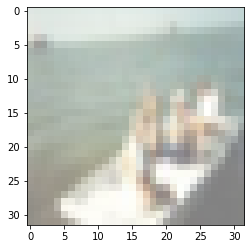

In [25]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelClassification.parameters(), lr=learning_rate)

In [27]:
num_epochs = 100
device = torch.device('cpu')

In [28]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        outputs = modelClassification(pixel_values=data)
        logits = outputs[0]
        loss = criterion(logits, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 0 Loss: 1.7664159536361694


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 1 Loss: 1.5363328456878662


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 2 Loss: 2.1764719486236572


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 3 Loss: 1.6342103481292725


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 4 Loss: 1.298985481262207


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 5 Loss: 1.2573175430297852


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 6 Loss: 1.443627953529358


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 7 Loss: 1.8281599283218384


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.7796991467475891


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 9 Loss: 1.2514439821243286


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 10 Loss: 1.1235840320587158


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.60024493932724


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.3884141147136688


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 13 Loss: 1.1200603246688843


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.5139546990394592


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.6440439224243164


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.8525748252868652


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 17 Loss: 1.417183518409729


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.3066483736038208


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.5687718987464905


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 20 Loss: 1.065653681755066


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 21 Loss: 0.3892928659915924


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 22 Loss: 0.4416012167930603


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 23 Loss: 0.3041522204875946


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 24 Loss: 0.32107070088386536


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 25 Loss: 0.6905975937843323


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 26 Loss: 0.050578922033309937


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 27 Loss: 0.7956045269966125


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 28 Loss: 0.04852501302957535


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 29 Loss: 0.9538877010345459


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 30 Loss: 0.6852439641952515


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 31 Loss: 0.6802964806556702


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 32 Loss: 0.1530335694551468


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 33 Loss: 0.45327964425086975


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 34 Loss: 0.3211398720741272


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 35 Loss: 0.046928491443395615


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 36 Loss: 0.09973769634962082


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 37 Loss: 0.3518294095993042


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 38 Loss: 0.37362387776374817


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 39 Loss: 0.24348922073841095


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 40 Loss: 0.049778129905462265


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 41 Loss: 0.35419711470603943


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 42 Loss: 0.03629195690155029


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 43 Loss: 0.14000433683395386


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 44 Loss: 0.15697042644023895


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 45 Loss: 0.4693017899990082


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 46 Loss: 0.003989832475781441


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 47 Loss: 0.005546908359974623


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 48 Loss: 0.13257436454296112


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 49 Loss: 0.41579514741897583


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 50 Loss: 0.03080371394753456


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 51 Loss: 0.15412738919258118


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 52 Loss: 0.25620341300964355


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 53 Loss: 0.16456188261508942


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 54 Loss: 0.4062195420265198


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 55 Loss: 0.016348298639059067


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 56 Loss: 0.13374808430671692


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 57 Loss: 0.1340343952178955


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 58 Loss: 0.2593410611152649


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 59 Loss: 0.7293619513511658


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 60 Loss: 0.29296547174453735


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 61 Loss: 0.05063819885253906


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 62 Loss: 0.15610739588737488


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 63 Loss: 0.4216987192630768


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 64 Loss: 0.014939872547984123


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 65 Loss: 0.06587964296340942


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 66 Loss: 0.023537280037999153


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 67 Loss: 0.008828789927065372


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 68 Loss: 0.09511955827474594


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 69 Loss: 0.0574779249727726


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 70 Loss: 0.09535901248455048


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 71 Loss: 0.30934661626815796


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 72 Loss: 0.1870858371257782


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 73 Loss: 0.1832883358001709


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 74 Loss: 0.046136293560266495


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 75 Loss: 0.2750365436077118


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 76 Loss: 0.056567154824733734


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 77 Loss: 0.06274381279945374


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 78 Loss: 0.005476408638060093


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 79 Loss: 0.18178647756576538


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 80 Loss: 0.035945527255535126


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 81 Loss: 0.022410675883293152


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 82 Loss: 0.25667834281921387


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 83 Loss: 0.25793176889419556


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 84 Loss: 0.018129276111721992


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 85 Loss: 0.0068640452809631824


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 86 Loss: 0.02984239161014557


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 87 Loss: 0.37207719683647156


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 88 Loss: 0.006756508722901344


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 89 Loss: 0.1374661922454834


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 90 Loss: 0.00034733640495687723


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 91 Loss: 0.361550897359848


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 92 Loss: 0.013444965705275536


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 93 Loss: 0.0031745336018502712


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 94 Loss: 0.013755963183939457


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 95 Loss: 0.4087858200073242


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 96 Loss: 0.16405749320983887


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 97 Loss: 0.030223455280065536


  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Epoch: 98 Loss: 0.01978149823844433


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [09:37<00:00,  1.35it/s]

Epoch: 99 Loss: 0.059542082250118256


In [29]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


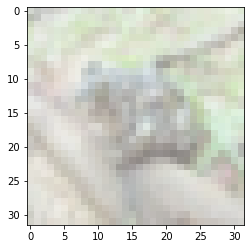

true label: frog
predict label: deer
index number: 1


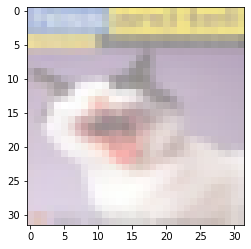

true label: cat
predict label: car
index number: 2


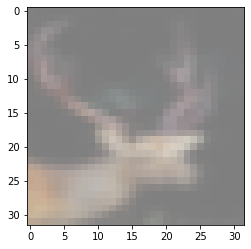

true label: deer
predict label: deer
index number: 3


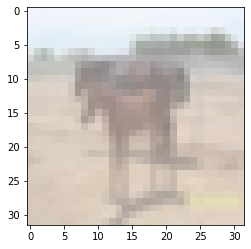

true label: horse
predict label: horse
index number: 4


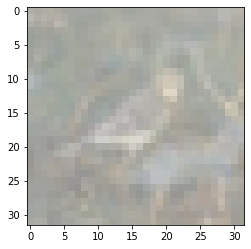

true label: bird
predict label: cat
index number: 5


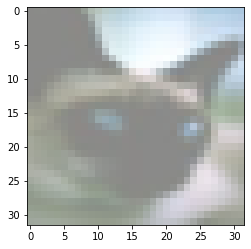

true label: cat
predict label: horse
index number: 6


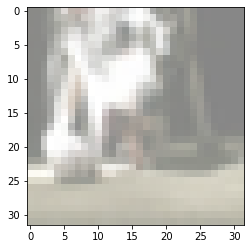

true label: dog
predict label: cat
index number: 7


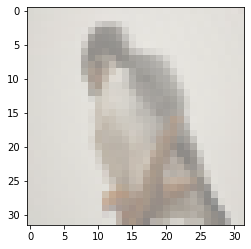

true label: bird
predict label: cat
index number: 8


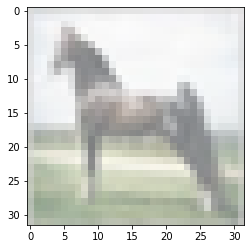

true label: horse
predict label: ship
index number: 9


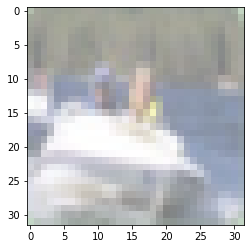

true label: ship
predict label: ship
index number: 10


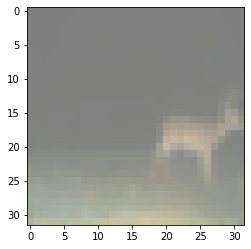

true label: deer
predict label: deer
index number:  


In [30]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    outputs = modelClassification(pixel_values=images.to(device=device))
    prediction = outputs[0]
    max_index = np.argmax(prediction[i,:].detach().numpy())
    print('predict label:',classes[max_index])